# Analysis of the performance test results.
The measurement is done by the fluid application itself, the define PERFORMANCE_TEST has to be set for this.  
See the CMakeLists.txt how to set it.  
The results are then saved in a csv-file.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Import the data.

In [2]:
# The here defined number of particles need to match with the order of the provided filenames.
number_of_particles = [216, 512, 1000, 1728, 4096]
# We analyse four different computation modes:
# 1. brute force implementation, one thread
# 2. brute force implementation, eight threads
# 3. spatial grid implementation, one thread
# 4. spatial grid implementation, eight threads
# For each we have multiple number of files, these are for the different number of particles.
filenames_brute_force_one_thread = [
    "./data/brute_force_one_thread_216_particles.csv",
    "./data/brute_force_one_thread_512_particles.csv",
    "./data/brute_force_one_thread_1000_particles.csv",
    "./data/brute_force_one_thread_1728_particles.csv",
    "./data/brute_force_one_thread_4096_particles.csv"
]
filenames_brute_force_eight_threads = [
    "./data/brute_force_eight_threads_216_particles.csv",
    "./data/brute_force_eight_threads_512_particles.csv",
    "./data/brute_force_eight_threads_1000_particles.csv",
    "./data/brute_force_eight_threads_1728_particles.csv",
    "./data/brute_force_eight_threads_4096_particles.csv"
]
filenames_spatial_grid_one_thread = [
    "./data/spatial_grid_one_thread_216_particles.csv",
    "./data/spatial_grid_one_thread_512_particles.csv",
    "./data/spatial_grid_one_thread_1000_particles.csv",
    "./data/spatial_grid_one_thread_1728_particles.csv",
    "./data/spatial_grid_one_thread_4096_particles.csv"
]
filenames_spatial_grid_eight_threads = [
    "./data/spatial_grid_eight_threads_216_particles.csv",
    "./data/spatial_grid_eight_threads_512_particles.csv",
    "./data/spatial_grid_eight_threads_1000_particles.csv",
    "./data/spatial_grid_eight_threads_1728_particles.csv",
    "./data/spatial_grid_eight_threads_4096_particles.csv"
]

In [3]:
# Each imported file has multiple rows. The entry in the function column indicates what function
# was measured. We need to map this function name to a better understandable name / a name that we 
# can use in the documentation.
function_name_to_task = {
    "application_handler.simulation_handler.simulate()": "total simulation time",
    "application_handler.visualization_handler.visualize()": "total visualization time",
    "this->parallel_for(&Particle_System::calculate_density_pressure_brute_force, this->number_of_particles)": "time for density and pressure calculation",
    "this->parallel_for(&Particle_System::calculate_acceleration_brute_force, this->number_of_particles)": "time for force and acceleration calculation",
    "this->parallel_for(&Particle_System::calculate_verlet_step_brute_force, this->number_of_particles)": "time for time integration",
    "this->parallel_for_grid(&Particle_System::calculate_density_pressure_spatial_grid)": "time for density and pressure calculation",
    "this->parallel_for_grid(&Particle_System::calculate_acceleration_spatial_grid)": "time for force and acceleration calculation",
    "this->parallel_for_grid(&Particle_System::calculate_verlet_step_spatial_grid)": "time for time integration"
}

In [10]:
# This function reads the data from the csv, converts it in a proper manner and calculates the statistics.
def read_data (filenames):
    df_collection = []
    for filename in filenames:
        #print("Load ", filename)
        # Read the file.
        df = pd.read_csv(filename, delimiter=";")
        # Check the number of rows, each csv file should only contain one computation mode (brute force or spatial grid),
        # and therefore in total only five measured functions.
        if len(df.index) != 5:
            print("ERROR too much entries in ", filename)
        # We need to translate the function name to a better name.
        df["function"].replace(function_name_to_task, inplace=True)
        # The measured times are currently in a string that represents the values as an array.
        # Transform it to a normal array.
        df["execution_times"] = df["execution_times"].apply(lambda x: np.array(x.split(','), dtype=int))
        # Also drop the first values, to not include some setup time that may introduce additional time.
        df["execution_times"] = df["execution_times"].apply(lambda x: x[5:])
        # Now calculate the total runtime , this is the sum of the simulation and visualization time.
        df = pd.concat([df,
            pd.DataFrame({
                "function": ["total execution time"],
                "execution_times": [df["execution_times"][df["function"] == "total visualization time"].values[0] + \
                    df["execution_times"][df["function"] == "total simulation time"].values[0]]})],
            ignore_index=True)
        # Now calculate some statistics on it.
        df["average"] = df["execution_times"].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
        df["min"] = df["execution_times"].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
        df["max"] = df["execution_times"].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
        df["std"] = df["execution_times"].apply(lambda x: np.std(x) if len(x) > 1 else np.nan)
        # Append it to the array of dataframes.
        df_collection.append(df)
    return df_collection

# Read the different data.
df_collection_brute_force_one_thread = read_data(filenames_brute_force_one_thread)
df_collection_brute_force_eight_threads = read_data(filenames_brute_force_eight_threads)
df_collection_spatial_grid_one_thread = read_data(filenames_spatial_grid_one_thread)
df_collection_spatial_grid_eight_threads = read_data(filenames_spatial_grid_eight_threads)


In [40]:
# A helper function to extract the needed data.
def get_execution_time(df_collection, function, statistical_property):
    result = []
    for df in df_collection:
        result.append(
            df[statistical_property][df["function"] == function].values[0]
        )
    return result

# Make the data easier accessible.
total_execution_time_brute_force_one_thread_average = get_execution_time(df_collection_brute_force_one_thread, "total execution time", "average")
total_execution_time_brute_force_one_thread_min = get_execution_time(df_collection_brute_force_one_thread, "total execution time", "min")
total_execution_time_brute_force_one_thread_max = get_execution_time(df_collection_brute_force_one_thread, "total execution time", "max")
total_execution_time_brute_force_one_thread_std = get_execution_time(df_collection_brute_force_one_thread, "total execution time", "std")
total_execution_time_brute_force_eight_threads_average = get_execution_time(df_collection_brute_force_eight_threads, "total execution time", "average")
total_execution_time_brute_force_eight_threads_min = get_execution_time(df_collection_brute_force_eight_threads, "total execution time", "min")
total_execution_time_brute_force_eight_threads_max = get_execution_time(df_collection_brute_force_eight_threads, "total execution time", "max")
total_execution_time_brute_force_eight_threads_std = get_execution_time(df_collection_brute_force_eight_threads, "total execution time", "std")
total_execution_time_spatial_grid_one_thread_average = get_execution_time(df_collection_spatial_grid_one_thread, "total execution time", "average")
total_execution_time_spatial_grid_one_thread_min = get_execution_time(df_collection_spatial_grid_one_thread, "total execution time", "min")
total_execution_time_spatial_grid_one_thread_max = get_execution_time(df_collection_spatial_grid_one_thread, "total execution time", "max")
total_execution_time_spatial_grid_one_thread_std = get_execution_time(df_collection_spatial_grid_one_thread, "total execution time", "std")
total_execution_time_spatial_grid_eight_threads_average = get_execution_time(df_collection_spatial_grid_eight_threads, "total execution time", "average")
total_execution_time_spatial_grid_eight_threads_min = get_execution_time(df_collection_spatial_grid_eight_threads, "total execution time", "min")
total_execution_time_spatial_grid_eight_threads_max = get_execution_time(df_collection_spatial_grid_eight_threads, "total execution time", "max")
total_execution_time_spatial_grid_eight_threads_std = get_execution_time(df_collection_spatial_grid_eight_threads, "total execution time", "std")

# We calculated the execution time until now, now transform it to the fps. Note that the min and max has to be switched.
fps_brute_force_one_thread_average = [1/(x / 1000) for x in total_execution_time_brute_force_one_thread_average]
fps_brute_force_one_thread_min = [1/(x / 1000) for x in total_execution_time_brute_force_one_thread_max]
fps_brute_force_one_thread_max = [1/(x / 1000) for x in total_execution_time_brute_force_one_thread_min]
fps_brute_force_one_thread_std = [1/(x / 1000) for x in total_execution_time_brute_force_one_thread_std]
fps_brute_force_eight_threads_average = [1/(x / 1000) for x in total_execution_time_brute_force_eight_threads_average]
fps_brute_force_eight_threads_min = [1/(x / 1000) for x in total_execution_time_brute_force_eight_threads_max]
fps_brute_force_eight_threads_max = [1/(x / 1000) for x in total_execution_time_brute_force_eight_threads_min]
fps_brute_force_eight_threads_std = [1/(x / 1000) for x in total_execution_time_brute_force_eight_threads_std]
fps_spatial_grid_one_thread_average = [1/(x / 1000) for x in total_execution_time_spatial_grid_one_thread_average]
fps_spatial_grid_one_thread_min = [1/(x / 1000) for x in total_execution_time_spatial_grid_one_thread_max]
fps_spatial_grid_one_thread_max = [1/(x / 1000) for x in total_execution_time_spatial_grid_one_thread_min]
fps_spatial_grid_one_thread_std = [1/(x / 1000) for x in total_execution_time_spatial_grid_one_thread_std]
fps_spatial_grid_eight_threads_average = [1/(x / 1000) for x in total_execution_time_spatial_grid_eight_threads_average]
fps_spatial_grid_eight_threads_min = [1/(x / 1000) for x in total_execution_time_spatial_grid_eight_threads_max]
fps_spatial_grid_eight_threads_max = [1/(x / 1000) for x in total_execution_time_spatial_grid_eight_threads_min]
fps_spatial_grid_eight_threads_std = [1/(x / 1000) for x in total_execution_time_spatial_grid_eight_threads_std]

## Plot the data.

In [44]:
# A helper function to get the area of the standard deviation.
def sum_of_lists (list1, list2):
    return [x + y for x, y in zip(list1, list2)]
def sub_of_lists (list1, list2):
    return [x - y for x, y in zip(list1, list2)]

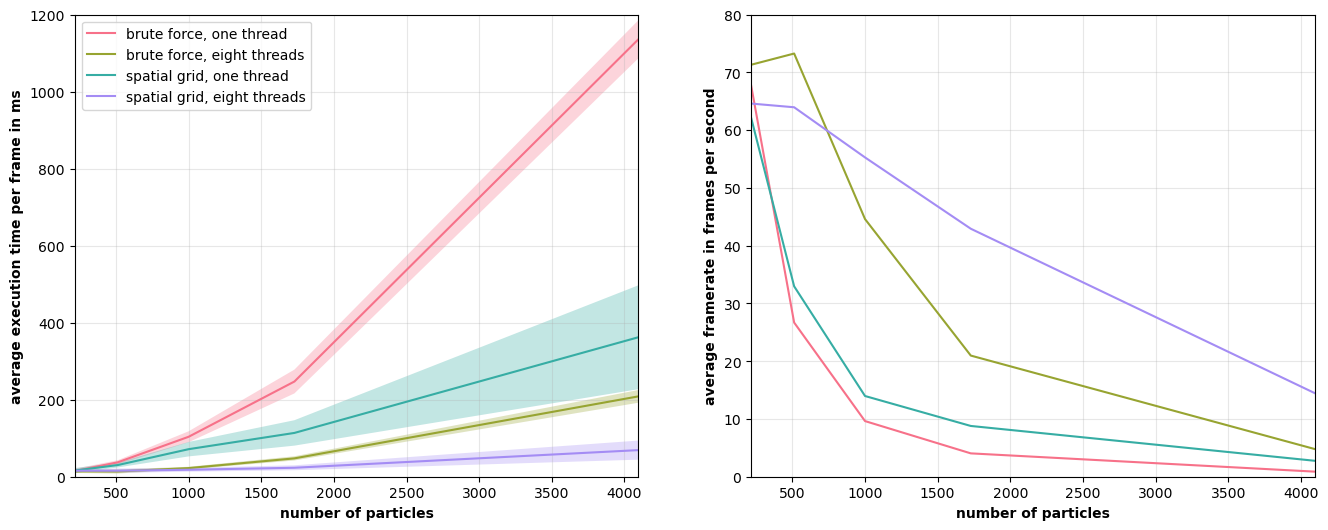

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
# We want a color palette.
# https://stackoverflow.com/questions/43064524/plotting-shaded-uncertainty-region-in-line-plot-in-matplotlib-when-data-has-nans
clrs = sns.color_palette("husl", 4)

# Plot at first the execution time.
# brute force, one thread
ax1.plot(number_of_particles, total_execution_time_brute_force_one_thread_average, label="brute force, one thread", c=clrs[0])
ax1.fill_between(number_of_particles, sub_of_lists(total_execution_time_brute_force_one_thread_average, total_execution_time_brute_force_one_thread_std), 
                sum_of_lists(total_execution_time_brute_force_one_thread_average, total_execution_time_brute_force_one_thread_std), 
                alpha=0.3, facecolor=clrs[0])
# brute force, eight threads
ax1.plot(number_of_particles, total_execution_time_brute_force_eight_threads_average, label="brute force, eight threads", c=clrs[1])
ax1.fill_between(number_of_particles, sub_of_lists(total_execution_time_brute_force_eight_threads_average, total_execution_time_brute_force_eight_threads_std), 
                sum_of_lists(total_execution_time_brute_force_eight_threads_average, total_execution_time_brute_force_eight_threads_std), 
                alpha=0.3, facecolor=clrs[1])
# spatial grid, one thread
ax1.plot(number_of_particles, total_execution_time_spatial_grid_one_thread_average, label="spatial grid, one thread", c=clrs[2])
ax1.fill_between(number_of_particles, sub_of_lists(total_execution_time_spatial_grid_one_thread_average, total_execution_time_spatial_grid_one_thread_std), 
                sum_of_lists(total_execution_time_spatial_grid_one_thread_average, total_execution_time_spatial_grid_one_thread_std), 
                alpha=0.3, facecolor=clrs[2])
# spatial grid, eight threads
ax1.plot(number_of_particles, total_execution_time_spatial_grid_eight_threads_average, label="spatial grid, eight threads", c=clrs[3])
ax1.fill_between(number_of_particles, sub_of_lists(total_execution_time_spatial_grid_eight_threads_average, total_execution_time_spatial_grid_eight_threads_std), 
                sum_of_lists(total_execution_time_spatial_grid_eight_threads_average, total_execution_time_spatial_grid_eight_threads_std), 
                alpha=0.3, facecolor=clrs[3])

# Now plot the fps.
# brute force, one thread
ax2.plot(number_of_particles, fps_brute_force_one_thread_average, label="brute force, one thread", c=clrs[0])
# brute force, eight threads
ax2.plot(number_of_particles, fps_brute_force_eight_threads_average, label="brute force, eight threads", c=clrs[1])
# spatial grid, one thread
ax2.plot(number_of_particles, fps_spatial_grid_one_thread_average, label="spatial grid, one thread", c=clrs[2])
# spatial grid, eight threads
ax2.plot(number_of_particles, fps_spatial_grid_eight_threads_average, label="spatial grid, eight threads", c=clrs[3])

# General visual settings.
label_weight = "bold"
xlabel = "number of particles"
ax1.set_xlabel(xlabel, weight=label_weight)
ax2.set_xlabel(xlabel, weight=label_weight)
ax1.set_ylabel("average execution time per frame in ms", weight=label_weight)
ax2.set_ylabel("average framerate in frames per second", weight=label_weight)
xlim = [min(number_of_particles), max(number_of_particles)]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
ax1.set_ylim([0, 1200])
ax2.set_ylim([0, 80])
grid_alpha = 0.3
ax1.grid(alpha=grid_alpha)
ax2.grid(alpha=grid_alpha)
ax1.legend()